# Sprint 2 Project
Team Patrisha: Adam, Bianca, Chatty, Louie, Matthew, Shawn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import keyring
import time

%matplotlib inline

-------------------------------------------
## Preliminaries
### Load data

In [2]:
charts_df = pd.read_csv('data/spotify_daily_charts.csv')
charts_df['date'] = pd.to_datetime(charts_df['date'])
tracks_df = pd.read_csv('data/spotify_daily_charts_tracks.csv')

df = charts_df.merge(tracks_df, on='track_id', how='left')
df = df.drop(columns='track_name_y')
df = df.rename(columns={'track_name_x':'track_name'})

### Identify relevant artists for the project-- Olivia Rodrigo, Harry Styles

<ipython-input-3-b066bcf9310e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sweet_spot["Artist"]=sweet_spot.index


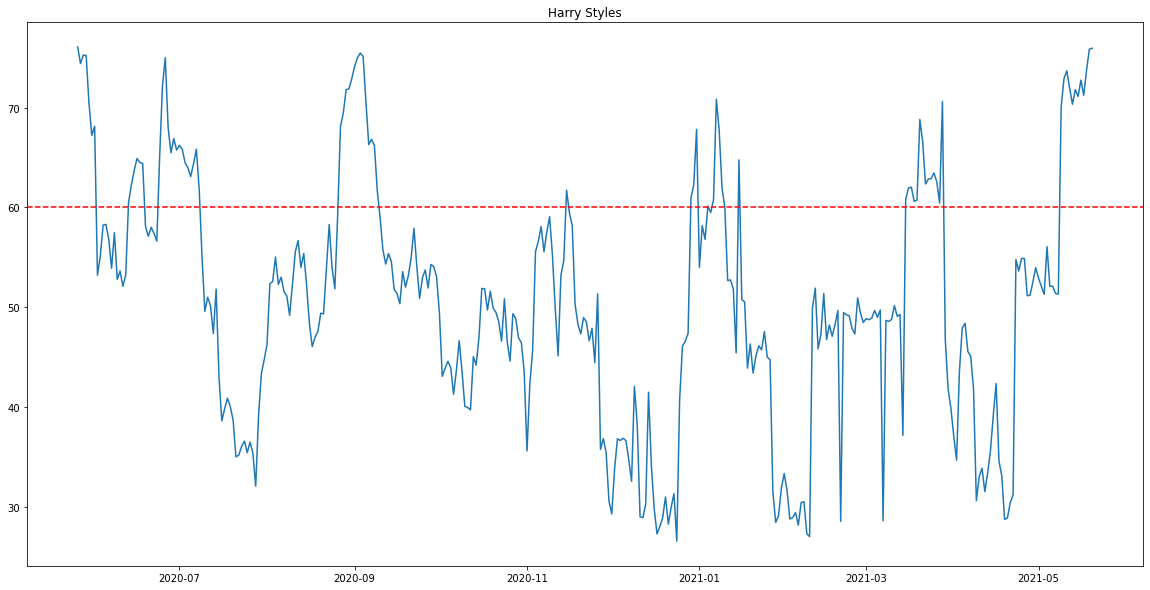

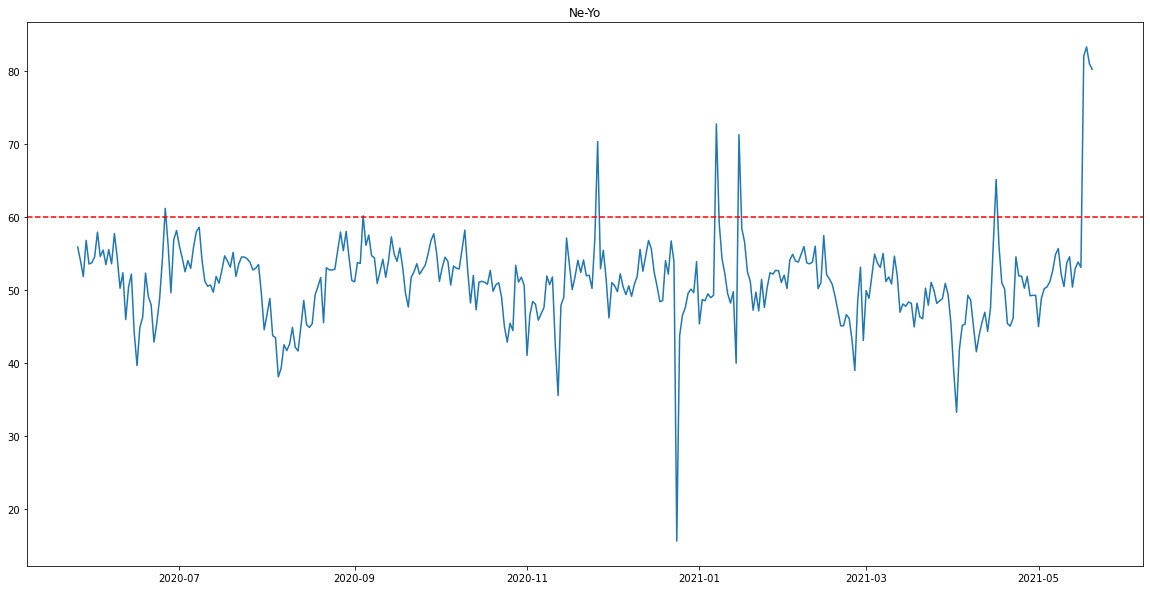

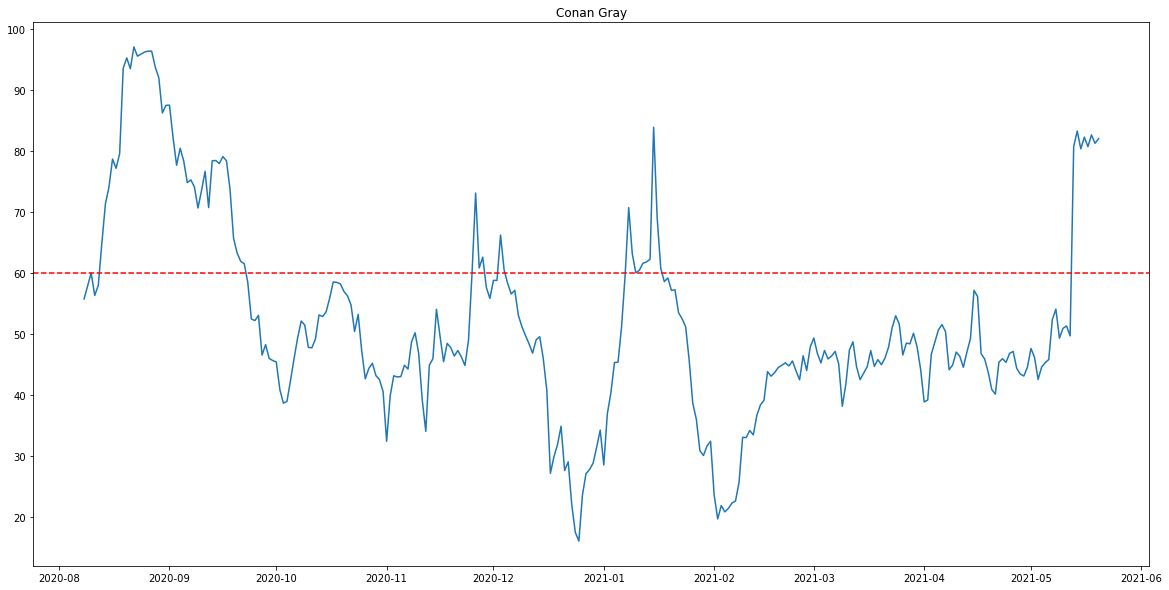

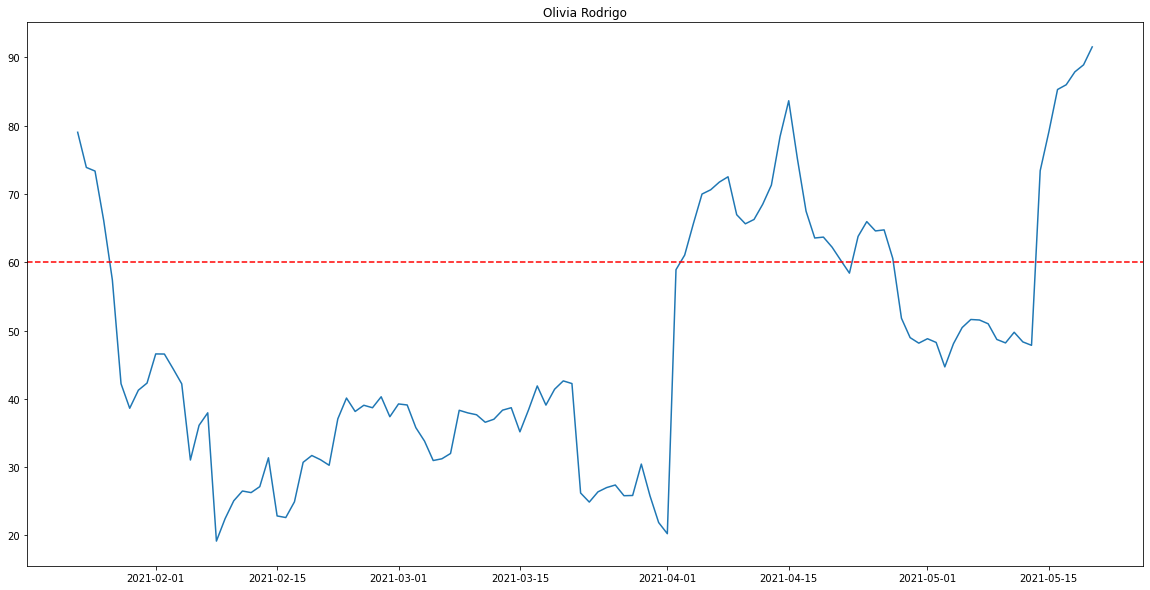

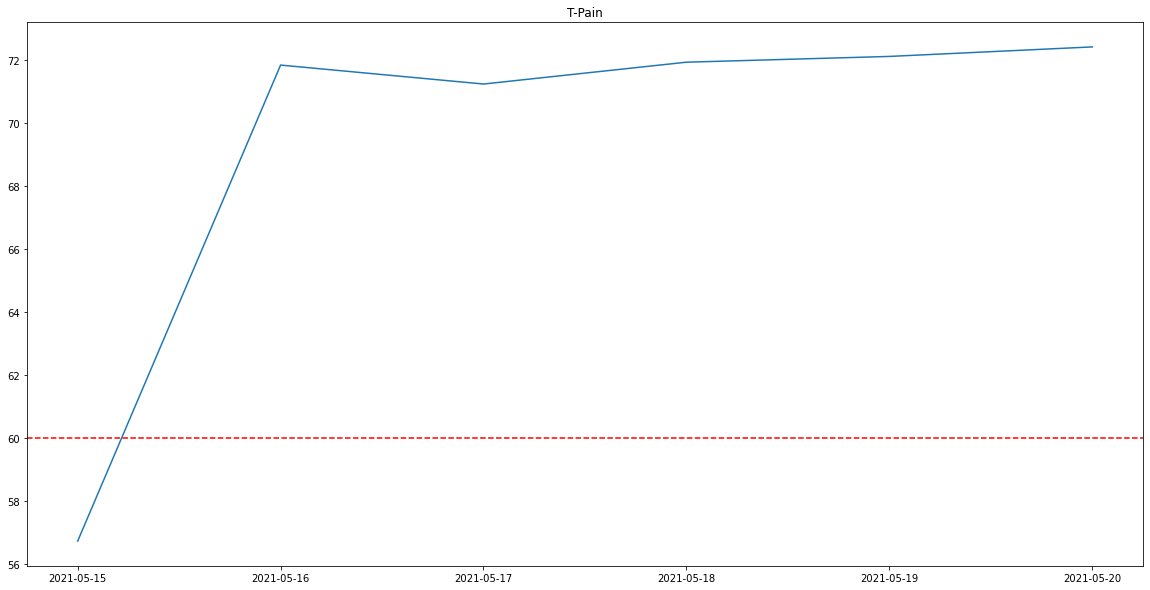

In [3]:
df2021 = df.set_index("date")['2020-5-12':'2021-5-20']
df2021["Date"]=df2021.index
trimmed = df2021[['Date', 'artist']].drop_duplicates(keep="first")
days_charted = trimmed.groupby('artist').count().sort_values("Date", ascending = False).rename(columns={"Date":"Day count"})
sweet_spot = days_charted[(days_charted["Day count"]>=90)&(days_charted["Day count"]<=200)]
sweet_spot["Artist"]=sweet_spot.index
#artist_list = [x for x in sweet_spot["Artist"]]

# artist_list=[x for x in df2021["artist_name"].unique()]
# df2021[df2021["artist"].isin(artist_list)]

# for i in artist_list:
#     filtered = df2021[df2021["artist"]==i][["streams"]].resample("D").sum().replace(0,np.nan)
#     plt.figure(figsize=(20,10))
#     plt.plot(filtered)
#     plt.title(i)
#     plt.show()

#https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
def StreamsRSI(Songs, interval = 14):
    start_date = Songs.index.min()+pd.Timedelta(days = interval)
    end_date=Songs.index.max()
    delta = Songs[["streams"]].resample("D").sum().diff()
    up,down = delta.clip(lower = 0), delta.clip(upper=0)
    rollup = up.rolling(interval).mean()
    rolldown = down.abs().rolling(interval).mean()
    RS = rollup / rolldown
    RSI = 100.0 - (100.0 / (1.0 + RS))
    fig = plt.figure(figsize=(20, 10))
    plt.title(Songs['artist_name'][0])
    plt.plot(RSI)
    plt.axhline(60,color='red',ls='--')    
    plt.show()
    return fig

artist_list = ["Harry Styles","Ne-Yo", "Conan Gray","Olivia Rodrigo",'T-Pain']
for i in artist_list:
    filtered = df2021[df2021["artist"]==i]
    try:
        fig = StreamsRSI(filtered)
        fig.savefig(i+'.png')
    except:
        print("Error at " + i)

### Identify seed tracks for Olivia Rodrigo and Harry Styles

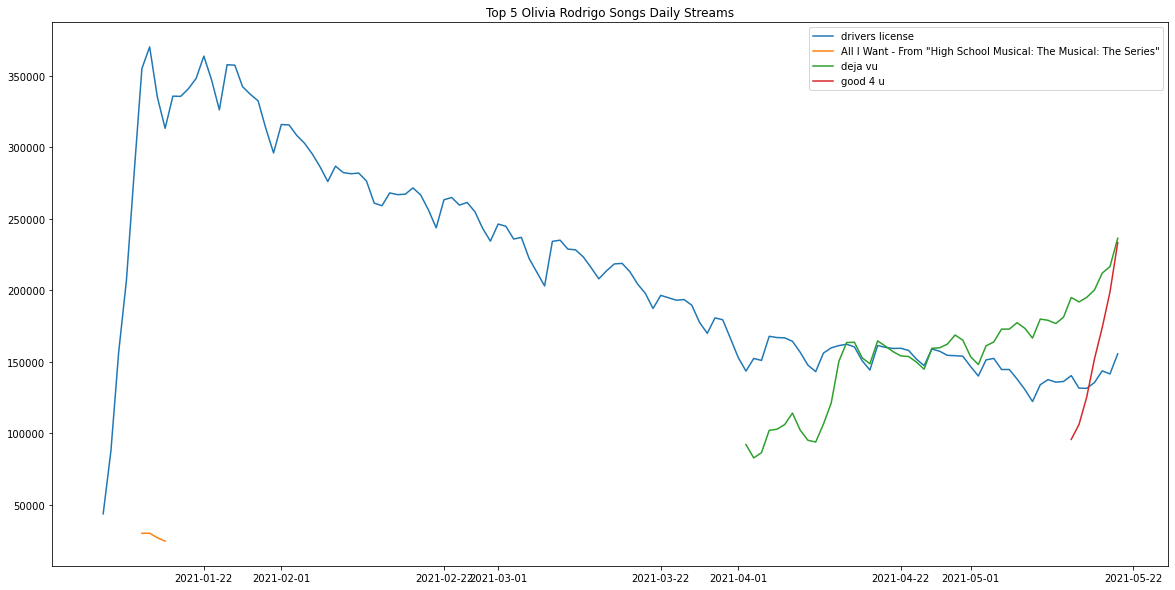

In [4]:
Olivia = df[df['artist_name']=="Olivia Rodrigo"].reset_index(drop=True)
top_streamed_Olivia = Olivia.groupby(["track_id"]).agg(Streams=("streams","sum")).sort_values("Streams", ascending=False)
Olivia_songs = Olivia[["track_id","track_name"]].drop_duplicates(keep="first")
Top_5_Olivia = pd.merge(top_streamed_Olivia,Olivia_songs, on="track_id", how="left").head()["track_id"]
Top_5_Olivia = [x for x in Top_5_Olivia]
Olivia_Top_5 = Olivia[Olivia["track_id"].isin(Top_5_Olivia)]
Olivia_Top_5 = Olivia_Top_5.set_index("date")

track_names_Olivia  = [x for x in Olivia_Top_5["track_name"].unique()]

plt.figure(figsize=(20,10))
for i in track_names_Olivia:
    streams = Olivia_Top_5[Olivia_Top_5["track_name"]==i]["streams"].resample("D").sum().replace(0,np.nan)
    plt.plot(streams,label=i)
plt.title("Top 5 Olivia Rodrigo Songs Daily Streams")
plt.legend()
plt.show()

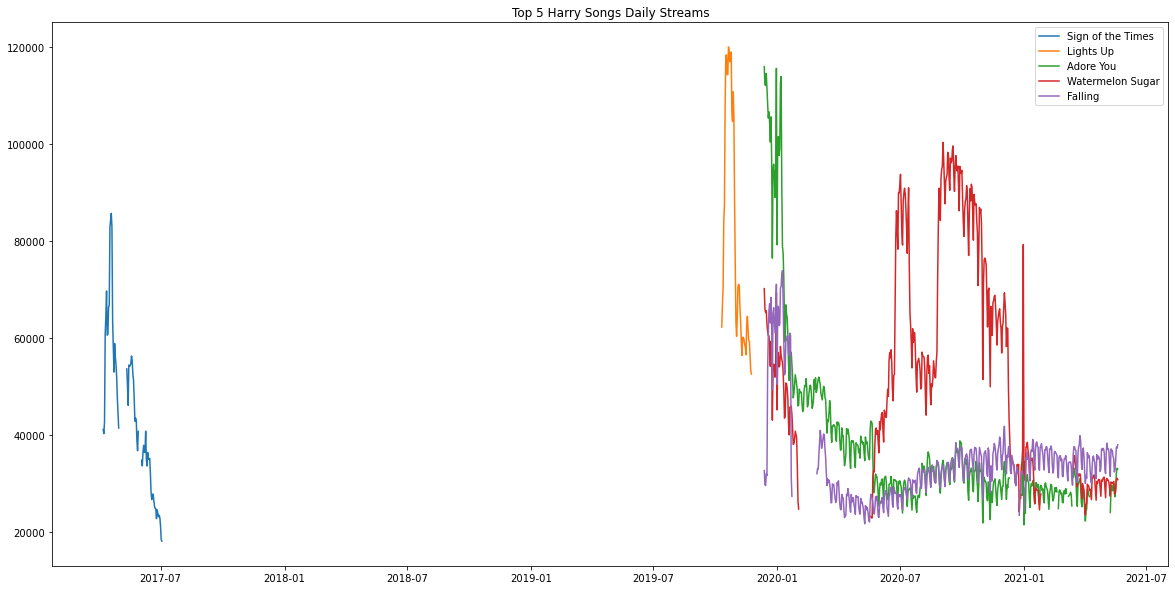

In [5]:
Harry = df[df['artist_name']=="Harry Styles"].reset_index(drop=True)
top_streamed_Harry = Harry.groupby(["track_id"]).agg(Streams=("streams","sum")).sort_values("Streams", ascending=False)
Harry_songs = Harry[["track_id","track_name"]].drop_duplicates(keep="first")
Top_5_Harry=pd.merge(top_streamed_Harry,Harry_songs, on="track_id", how="left").head()["track_id"]
Top_5_Harry = [x for x in Top_5_Harry]
Harry_Top_5 = Harry[Harry["track_id"].isin(Top_5_Harry)]
Harry_Top_5 = Harry_Top_5.set_index("date")

track_names_Harry  = [x for x in Harry_Top_5["track_name"].unique()]

plt.figure(figsize=(20,10))
for i in track_names_Harry:
    streams = Harry_Top_5[Harry_Top_5["track_name"]==i]["streams"].resample("D").sum().replace(0,np.nan)
    plt.plot(streams,label=i)
plt.title("Top 5 Harry Songs Daily Streams")
plt.legend()
plt.show()

From these charts, main seed tracks for **Olivia Rodrigo** and **Harry Styles** are **drivers license** and **Watermelon Sugar**, respectively.

## KNN Model for Recommender Engine Pool

In [6]:
genre_names = ["Classical", "Electronic", "Pop", "Reggae", "Rap", "Jazz"] #added jazz

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)

tracks_df['genre'].value_counts()

Classical
Electronic
Pop
Reggae
Rap
Jazz


electronic    2536
classical     2441
jazz          1746
reggae        1668
pop           1651
rap           1318
Name: genre, dtype: int64

In [7]:
playlist_df.shape, tracks_df.shape

((541, 7), (11360, 22))

In [8]:
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [9]:
playlist_df[playlist_df.isnull().any(1)]

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre


In [10]:
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(11356, 22)

In [11]:
len(tracks_df['track_id'].unique())

11107

In [12]:
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(11107, 22)

In [13]:
top_playlists_df = playlist_df.groupby('genre').head(10)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWWEJlAGA9gs0,Classical Essentials,172,spotify,Spotify,2244056,classical
1,37i9dQZF1DWV0gynK7G6pD,Classical New Releases,50,spotify,Spotify,573403,classical
2,37i9dQZF1DX9G9wwzwWL2k,Epic Classical,107,spotify,Spotify,469103,classical
3,37i9dQZF1DWUvHZA1zLcjW,Chilled Classical,92,spotify,Spotify,413914,classical
4,37i9dQZF1DX8Sz1gsYZdwj,Classical Sleep,72,spotify,Spotify,362560,classical


In [14]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz          1105
electronic     852
reggae         837
classical      777
pop            764
rap            567
Name: genre, dtype: int64

In [15]:
# balTrack = pd.DataFrame()
# for genre in tracks_df['genre'].unique():
#     temp = tracks_df[tracks_df['genre']==genre].sample(tracks_df['genre'].value_counts().min(), random_state = 42)
#     balTrack = pd.concat([balTrack,temp])

# tracks_df = balTrack.copy()
# tracks_df['genre'].value_counts()

In [16]:
tracks_df['duration_mins']=tracks_df['duration']/60000
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
tracks_df["genre"] = tracks_df["genre"].astype('category')

In [17]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,4SFBV7SRNG2e2kyL1F6kjU,"The Well-Tempered Clavier: Book 1, BWV 846-869...",5aIqB5nVVvmFsvSdExz408,Johann Sebastian Bach,1XORY4rQNhqkZxTze6Px90,139306,2019-03-29,67,0.2210,0.1260,...,0.989,0.897,0.1020,0.2160,0.611879,37i9dQZF1DWWEJlAGA9gs0,classical,Classical Essentials,2.321767,0
1,2kAgCRZPG3YQR2VMqRvLmb,The Lark Ascending,7wNkISK49lKeXuRaZcQVFe,Ralph Vaughan Williams,1Dki2WNHBcFGSs4ZACDBfq,935360,2013,66,0.0811,0.0122,...,0.902,0.308,0.0648,0.0384,0.341375,37i9dQZF1DWWEJlAGA9gs0,classical,Classical Essentials,15.589333,0
2,1upQiytDIEZfl9ItruoXuC,Handel / Orch. Hale: Keyboard Suite in D Minor...,1QL7yTHrdahRMpvNtn6rI2,George Frideric Handel,657D9POYWMrDMK9MWNxPHL,207266,2002,68,0.2040,0.0331,...,0.927,0.825,0.0954,0.0547,0.532068,37i9dQZF1DWWEJlAGA9gs0,classical,Classical Essentials,3.454433,0
3,0H2VhGUC3P3hvwz8rdGIpC,"Bagatelle No. 25 in A Minor, ""Für Elise"", WoO 59",2wOqMjp9TyABvtHdOSOTUS,Ludwig van Beethoven,74YXY7P1wuM4JR9hGDzPBx,203655,2019-01-18,64,0.2300,0.0487,...,0.986,0.945,0.0679,0.1010,0.617414,37i9dQZF1DWWEJlAGA9gs0,classical,Classical Essentials,3.394250,0
4,419qlOGNXoyICx4jO0hqaj,"Rhapsody On A Theme Of Paganini, Op.43: Variat...",0Kekt6CKSo0m5mivKcoH51,Sergei Rachmaninoff,7lj4fT2SzKOFw8rvSrVivF,174653,2015-08-28,62,0.2050,0.0525,...,0.980,0.906,0.1030,0.0511,0.404390,37i9dQZF1DWWEJlAGA9gs0,classical,Classical Essentials,2.910883,0


In [18]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{0: 'classical', 1: 'electronic', 3: 'pop', 5: 'reggae', 4: 'rap', 2: 'jazz'}


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(3921, 8)
Shape of y_Train:(3921,)
Shape of X_Test:(981, 8)
Shape of y_Test:(981,)
Finding best k...


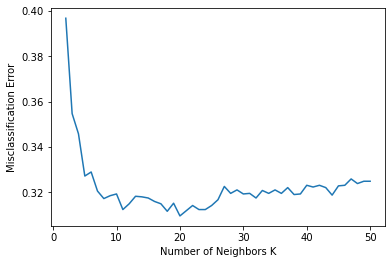

The optimal number of neighbors is 20 with score 69%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(3921, 8)
Shape of y_Train:(3921,)
Shape of X_Test:(981, 8)
Shape of y_Test:(981,)
Finding best k...


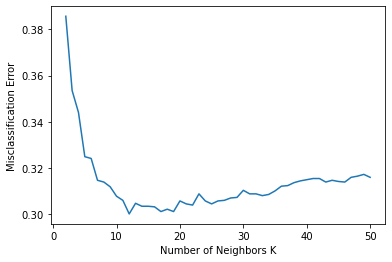

The optimal number of neighbors is 12 with score 69%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(3921, 8)
Shape of y_Train:(3921,)
Shape of X_Test:(981, 8)
Shape of y_Test:(981,)
Finding best k...


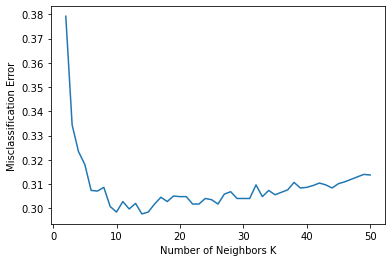

The optimal number of neighbors is 14 with score 70%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(3921, 8)
Shape of y_Train:(3921,)
Shape of X_Test:(981, 8)
Shape of y_Test:(981,)
Finding best k...


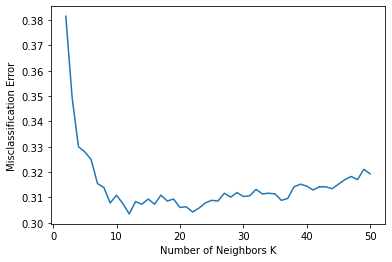

The optimal number of neighbors is 12 with score 69%


In [19]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))

In [20]:
results_optimal_k

[20, 12, 14, 12]

In [21]:
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df = chart_tracks_df.dropna()
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [22]:
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

In [23]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)

charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)


chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

Predicting with optimal k: 12


## Scrape tracks for Olivia Rodrigo and Harry Styles

In [24]:
client_credentials_manager = SpotifyClientCredentials(client_id=keyring.get_password('spotify', 'cid'),
                                                      client_secret=keyring.get_password('spotify', 'secret') )
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [25]:
# album_ids, album_names, album_numtracks = [], [], []

# seed_artists = ['6KImCVD70vtIoJWnq6nGn3','1McMsnEElThX1knmY4oliG']

# for seed in seed_artists:
#     r1 = sp.artist_albums(seed, album_type="album")
#     album_ids.extend([p['href'].split('/')[5] for p in r1['items']])
#     album_names.extend([p['name'] for p in r1['items']])
#     album_numtracks.extend([p['total_tracks'] for p in r1['items']])
    
#     r2 = sp.artist_albums(seed, album_type="single")
#     album_ids.extend([p['href'].split('/')[5] for p in r2['items']])
#     album_names.extend([p['name'] for p in r2['items']])
#     album_numtracks.extend([p['total_tracks'] for p in r2['items']])
    
# album_names

In [26]:
# def get_relevant_track_data(tracks_data, album_id, album_name):
#     try:
#         relevant_track_data = { key: tracks_data[key] for key in ['id','artists','name','duration_ms'] }
#         relevant_track_data['artist_id']=[artist['id'] for artist in relevant_track_data['artists'] ]
#         relevant_track_data['artist_name']=[artist['name']for artist in relevant_track_data['artists'] ]
#         relevant_track_data['num_artists']=len([artist['id'] for artist in relevant_track_data['artists']]) 
#         relevant_track_data['album_id']= album_id
#         relevant_track_data['album_name']=album_name
        
#         relevant_track_data.pop('artists', None)
#         return relevant_track_data
#     except:
#         return 

In [27]:
# album_df = pd.DataFrame({'album_id': album_ids, 'album_name': album_names,'album_total_tracks': album_numtracks})
# all_track_data = []

# for _,p_id,p_name, p_numtracks in album_df[['album_id','album_name','album_total_tracks']].to_records():
#     print("Fetching data for album = %s, with total tracks: %d" % (p_name,p_numtracks))
    
#     album_track_data = []
#     track_data = sp.album_tracks(p_id)
#     album_track_data.extend([get_relevant_track_data(item, p_id,p_name) for item in track_data['items']])
        
#     all_track_data.extend(album_track_data)

In [28]:
# seed_tracks_df = pd.DataFrame([data for data in all_track_data if data is not None])
# seed_tracks_df = seed_tracks_df.rename(columns={'id':'track_id'})
# seed_tracks_df['artist_id'] = seed_tracks_df.apply(lambda x: x['artist_id'][0] if x['num_artists']==1 else x['artist_id'], axis=1)
# seed_tracks_df['artist_name'] = seed_tracks_df.apply(lambda x: x['artist_name'][0] if x['num_artists']==1 else x['artist_name'], axis=1)
# seed_tracks_df.head()

In [29]:
# seed_tracks_df.to_csv("data/album_tracks.csv",encoding='utf=8',index=False)

In [30]:
# def get_track_data(t_id, album_id, album_name):                    
#     track_data = sp.track(t_id)
#     track_features = sp.audio_features(t_id)
    
#     #get only main(first) artist
#     td_list = [t_id,\
#                track_data['name'],\
#                track_data['artists'][0]['id'],\
#                track_data['artists'][0]['name'],\
#                track_data['album']['uri'].split(":")[2],\
#                track_data['duration_ms'],\
#                track_data['album']['release_date'],\
#                track_data['popularity']]
#     data = pd.DataFrame([td_list], columns = ['track_id','track_name','artist_id','artist_name','album_id','duration','release_date','popularity'])

#     relevant_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',\
#                      'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']  
    
#     tf_data = pd.DataFrame(track_features)
#     tf_data = tf_data[relevant_cols]
#     #tag with source album
#     tf_data['album_id'] = album_id
#     tf_data['album_name'] = album_name
    
#     data = pd.concat([data, tf_data], axis=1)
#     return data

In [31]:
# track_list = seed_tracks_df['track_id'].values
# album_name_list = seed_tracks_df['album_name'].values
# album_id_list = seed_tracks_df['album_id'].values
# df_list=[]
# downloaded_track_data = []

# for i,track_id in enumerate(track_list):
#     try:
#         if track_id not in downloaded_track_data:
#             print('[%d/%d] Fetching track data for %s... ' % 
#                 (i+1,len(track_list),seed_tracks_df[seed_tracks_df['track_id']==track_id]['name'].values[0]), end = " ") 
#             track_data = get_track_data(track_id, album_id_list[i],album_name_list[i]) 
#             df_list.append(track_data)
#             downloaded_track_data.append(track_id)
#             print('done!')
#     except:
#         continue
#     else:
#         continue
    
#     #sleep for 60 secs per 100 requests to avoid being blocked
#     if (i % 100 == 0)&(i > 0):
#         time.sleep(20)    

In [32]:
# seed_tracks_data_df = pd.concat(df_list)
# seed_tracks_data_df.head()

In [33]:
# seed_tracks_data_df.to_csv("data/album_tracks_data.csv", index=False, encoding='utf-8')

### Predict genres of each track in the artists' albums

In [34]:
#scraped data in the drive folder

## Recommender Engine

In [35]:
seed_track_names = ["drivers license","Watermelon Sugar"]
seed_artists = ["Olivia Rodrigo", "Harry Styles"]

reco_tracks_df = chart_tracks_df[~chart_tracks_df['artist_name'].isin(seed_artists)].copy()

for seed_track_name in seed_track_names:
    seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
    reco_tracks_df['cosine_dist'] = reco_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                    seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                     .flatten()[0], axis=1)
    print('Recommendations for ', seed_track_name, ': Most Similar, by cosine distance')
    recommendation_df = reco_tracks_df[reco_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\
                                    [reco_tracks_df['track_id']!=seed_track_data['track_id']]\
                                    .sort_values('cosine_dist')[:11]
    display(recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre','track_id']+feature_cols])
    print(recommendation_df['track_id'].values)
    print('------------'*10)
    print('Recommendations for ', seed_track_name, ': Most Dissimilar, by cosine distance')
    recommendation_df_opposite = reco_tracks_df[reco_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\
                                    [reco_tracks_df['track_id']!=seed_track_data['track_id']]\
                                    .sort_values('cosine_dist', ascending = False)[:11]
    display(recommendation_df_opposite[['track_name','artist_name','cosine_dist','predicted_genre','track_id']+feature_cols])
    print(recommendation_df_opposite['track_id'].values)
    print('------------'*10)

Recommendations for  drivers license : Most Similar, by cosine distance


<ipython-input-35-ba9fa70dc161>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommendation_df = reco_tracks_df[reco_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\


,track_name,artist_name,cosine_dist,predicted_genre,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
83,The Scientist,Coldplay,0.003015,pop,75JFxkI2RXiU7L9VXzMkle,0.557,0.442,0.697073,0.0243,0.731,0.000015,0.1100,0.2130,0.576582
2302,Imahe,Magnus Haven,0.004216,pop,65sEZZaxTjLMD8vNgPoMz5,0.604,0.446,0.664893,0.0341,0.630,0.000000,0.0859,0.1990,0.562239
3082,Before It Sinks In,Moira Dela Torre,0.004511,pop,20JlaQj9irFjFb8X0SKKS7,0.542,0.392,0.659775,0.0355,0.605,0.000000,0.0798,0.1850,0.537996
182,Friend of Mine,Juris,0.004534,pop,5hWHHBX801NeP6jpt9mquW,0.518,0.457,0.681842,0.0271,0.649,0.000007,0.1360,0.1680,0.513112
327,Kung Wala Ka,Hale,0.005940,pop,6y0BUUOjU4TtqoBwoFwcvU,0.494,0.347,0.698424,0.0266,0.702,0.002390,0.1030,0.1440,0.515389
686,Kung Wala Ka,Hale,0.006009,pop,4JSDhJVmo2UqdF7nxbyenn,0.500,0.339,0.693920,0.0263,0.710,0.002220,0.1080,0.1520,0.515974
201,This Time (Original Movie Soundtrack),James Reid,0.008061,pop,1wv76JKLy8fgpIa4n6JuMa,0.552,0.491,0.674473,0.0306,0.687,0.000000,0.1390,0.2220,0.452208
137,Make Me (Cry),Noah Cyrus,0.008635,pop,2BrzlUj1u1CtvaJDGIKpsP,0.588,0.471,0.694493,0.0577,0.592,0.001460,0.0733,0.2090,0.617218
276,If I Ain't Got You,Alicia Keys,0.009453,pop,3XVBdLihbNbxUwZosxcGuJ,0.609,0.444,0.619079,0.1060,0.603,0.000007,0.1040,0.1660,0.405063
2896,the 1,Taylor Swift,0.009624,pop,0Jlcvv8IykzHaSmj49uNW8,0.777,0.357,0.708618,0.0522,0.757,0.000007,0.1080,0.1720,0.537239


['75JFxkI2RXiU7L9VXzMkle' '65sEZZaxTjLMD8vNgPoMz5'
 '20JlaQj9irFjFb8X0SKKS7' '5hWHHBX801NeP6jpt9mquW'
 '6y0BUUOjU4TtqoBwoFwcvU' '4JSDhJVmo2UqdF7nxbyenn'
 '1wv76JKLy8fgpIa4n6JuMa' '2BrzlUj1u1CtvaJDGIKpsP'
 '3XVBdLihbNbxUwZosxcGuJ' '0Jlcvv8IykzHaSmj49uNW8'
 '2qG81jL9UIP54uS8gYyP4k']
------------------------------------------------------------------------------------------------------------------------
Recommendations for  drivers license : Most Dissimilar, by cosine distance


<ipython-input-35-ba9fa70dc161>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommendation_df_opposite = reco_tracks_df[reco_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\


,track_name,artist_name,cosine_dist,predicted_genre,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3440,Intro : The Invitation,ENHYPEN,0.324254,pop,6gGpF8V8miC4O0GZUqSZ9a,0.283,0.806,0.746489,0.0555,0.004420,0.243000,0.2830,0.2610,0.092784
3340,Cloud 9,Beach Bunny,0.318271,pop,6vFsBXYczYsP0H3lgunZOm,0.637,0.929,0.845732,0.0491,0.001670,0.000026,0.3440,0.9020,0.174762
2794,Freedom (feat. Kendrick Lamar),Beyoncé,0.311656,pop,7aBxcRw77817BrkdPChAGY,0.437,0.803,0.730317,0.3050,0.037600,0.000000,0.6830,0.4060,0.195708
679,Given Up,Linkin Park,0.300605,pop,2Sru5y6R0mYhV9nEHMDWJ7,0.655,0.885,0.824319,0.0438,0.001170,0.000473,0.0448,0.9380,0.292374
1843,You Make It Feel Like Christmas (feat. Blake S...,Gwen Stefani,0.299764,pop,2OQ6a4CfUeYskpTTgyawyJ,0.635,0.870,0.817155,0.0400,0.015600,0.000000,0.1180,0.9120,0.248760
2888,Kiss You,One Direction,0.299702,pop,0AkQbXGN4KG34TS7xLrM68,0.630,0.934,0.888066,0.0589,0.018600,0.000000,0.3240,0.9050,0.230251
2614,Alone Again,The Weeknd,0.296165,pop,6b5P51m8xx2XA6U7sdNZ5E,0.218,0.652,0.667226,0.0641,0.033000,0.111000,0.1720,0.0599,0.078779
2053,Intro : Persona,BTS,0.293154,pop,2isSdmQfVv32j2haL6hk9x,0.469,0.870,0.809621,0.3420,0.027800,0.000000,0.3130,0.6520,0.209515
2364,Welcome to the Black Parade,My Chemical Romance,0.288306,pop,5wQnmLuC1W7ATsArWACrgW,0.217,0.905,0.824852,0.0752,0.000289,0.000110,0.2220,0.2360,0.273065
1363,Give Yourself A Try,The 1975,0.287532,pop,619pVMIK3WvX529JIkQTY3,0.331,0.784,0.788045,0.0561,0.000031,0.000000,0.4270,0.9020,0.802323


['6gGpF8V8miC4O0GZUqSZ9a' '6vFsBXYczYsP0H3lgunZOm'
 '7aBxcRw77817BrkdPChAGY' '2Sru5y6R0mYhV9nEHMDWJ7'
 '2OQ6a4CfUeYskpTTgyawyJ' '0AkQbXGN4KG34TS7xLrM68'
 '6b5P51m8xx2XA6U7sdNZ5E' '2isSdmQfVv32j2haL6hk9x'
 '5wQnmLuC1W7ATsArWACrgW' '619pVMIK3WvX529JIkQTY3'
 '2SasoXZyv82yYgHiVOvxQn']
------------------------------------------------------------------------------------------------------------------------
Recommendations for  Watermelon Sugar : Most Similar, by cosine distance


<ipython-input-35-ba9fa70dc161>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommendation_df = reco_tracks_df[reco_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\


,track_name,artist_name,cosine_dist,predicted_genre,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1772,Beach House,The Chainsmokers,0.001671,pop,0N8MGHEDAq29ip7RrlrTeN,0.537,0.837,0.809539,0.0390,0.190000,0.000000,0.348,0.533,0.230811
2810,Secret Story of the Swan,IZ*ONE,0.003300,pop,3FARQP8fA49bSsTWjNyWmY,0.703,0.941,0.952098,0.0808,0.131000,0.000000,0.319,0.758,0.310101
3404,Tell Me Why (Taylor’s Version),Taylor Swift,0.003594,pop,0k0vFacOHNuArLWMiH60p7,0.578,0.909,0.842620,0.0628,0.022200,0.000000,0.333,0.541,0.291974
397,Hymn for the Weekend,Coldplay,0.005558,pop,3RiPr603aXAoi4GHyXx0uy,0.491,0.693,0.727247,0.0377,0.211000,0.000007,0.325,0.412,0.230467
2895,Last First Kiss,One Direction,0.005810,pop,4RpsltwxERLiq6AXU39Dhx,0.531,0.811,0.888188,0.0426,0.056300,0.000000,0.272,0.484,0.181937
2784,SWEET SUMMER DAY,TWICE,0.005940,pop,6UrML9LyuaBWgZV3nFLLGl,0.707,0.950,0.862272,0.0645,0.018700,0.000011,0.350,0.589,0.353542
2792,SWEET SUMMER DAY,TWICE,0.005940,pop,4XDWKodqvKyGL5YJILpKM5,0.707,0.950,0.862272,0.0645,0.018700,0.000011,0.350,0.589,0.353542
2524,Ang Pinagmulan,IV Of Spades,0.005979,pop,45Nm4dwbrahPabtJQj8Cf0,0.550,0.763,0.748905,0.0345,0.003660,0.020600,0.226,0.532,0.261066
2455,Call You Mine,The Chainsmokers,0.006108,pop,2oejEp50ZzPuQTQ6v54Evp,0.585,0.696,0.763562,0.0307,0.204000,0.000000,0.344,0.522,0.316506
598,Don't Quit (feat. Travis Scott & Jeremih),DJ Khaled,0.006321,pop,4vv1KjUzPwrtDbozizSfQc,0.652,0.827,0.829887,0.0445,0.015000,0.000000,0.432,0.659,0.291900


['0N8MGHEDAq29ip7RrlrTeN' '3FARQP8fA49bSsTWjNyWmY'
 '0k0vFacOHNuArLWMiH60p7' '3RiPr603aXAoi4GHyXx0uy'
 '4RpsltwxERLiq6AXU39Dhx' '6UrML9LyuaBWgZV3nFLLGl'
 '4XDWKodqvKyGL5YJILpKM5' '45Nm4dwbrahPabtJQj8Cf0'
 '2oejEp50ZzPuQTQ6v54Evp' '4vv1KjUzPwrtDbozizSfQc'
 '7hvO2qCwJVZxiyoA7c9i5d']
------------------------------------------------------------------------------------------------------------------------
Recommendations for  Watermelon Sugar : Most Dissimilar, by cosine distance


<ipython-input-35-ba9fa70dc161>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommendation_df_opposite = reco_tracks_df[reco_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\


,track_name,artist_name,cosine_dist,predicted_genre,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1132,Heaven,Julia Michaels,0.291325,pop,3cysp2UU6xmV61ZlnQsa8s,0.554,0.371,0.620102,0.0361,0.853,0.000000,0.0838,0.246,0.906066
1122,Heaven,Julia Michaels,0.280024,pop,4QfNOZN7vrQCQKK1ZJ3XPb,0.544,0.379,0.619734,0.0412,0.863,0.000000,0.0830,0.322,0.905647
413,Yellow - Live from Spotify London,Coldplay,0.269061,pop,33koOQs551ijjVmLbmrcDc,0.223,0.439,0.564749,0.0312,0.447,0.014100,0.9260,0.119,0.697320
1600,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,0.268707,pop,7aW2GrNlteWTwQZxX6LNjT,0.264,0.273,0.638649,0.0312,0.535,0.000000,0.2070,0.315,0.911930
2537,To Die For,Sam Smith,0.250673,pop,2ZTYlnhhV1UAReg7wIGolx,0.483,0.361,0.669846,0.0738,0.832,0.000005,0.0980,0.307,0.732700
601,Fall for You (Acoustic),Secondhand Serenade,0.235850,pop,5V7mTIcXVU9k2JNu0mE6vy,0.433,0.307,0.632712,0.0327,0.650,0.000000,0.0635,0.378,0.772481
1963,Rock with You,Paolo Sandejas,0.231673,pop,4Bt8Ly7wwutPbX1dHXhuok,0.567,0.334,0.672549,0.0322,0.653,0.000000,0.1130,0.178,0.721926
2458,Nobela,Julie Anne San Jose,0.225370,pop,507wQHSkMb1MFJfN2fjpMQ,0.558,0.385,0.716070,0.0294,0.766,0.000000,0.0878,0.122,0.144242
2350,Closed On Sunday,Kanye West,0.224058,pop,3JWiDGQX2eTlFvKj3Yssj3,0.799,0.291,0.691791,0.0318,0.873,0.000641,0.1390,0.406,0.279428
686,Kung Wala Ka,Hale,0.222611,pop,4JSDhJVmo2UqdF7nxbyenn,0.500,0.339,0.693920,0.0263,0.710,0.002220,0.1080,0.152,0.515974


['3cysp2UU6xmV61ZlnQsa8s' '4QfNOZN7vrQCQKK1ZJ3XPb'
 '33koOQs551ijjVmLbmrcDc' '7aW2GrNlteWTwQZxX6LNjT'
 '2ZTYlnhhV1UAReg7wIGolx' '5V7mTIcXVU9k2JNu0mE6vy'
 '4Bt8Ly7wwutPbX1dHXhuok' '507wQHSkMb1MFJfN2fjpMQ'
 '3JWiDGQX2eTlFvKj3Yssj3' '4JSDhJVmo2UqdF7nxbyenn'
 '0Jlcvv8IykzHaSmj49uNW8']
------------------------------------------------------------------------------------------------------------------------


## Linear Regression Model for streams prediction

In [36]:
tracks_df = pd.read_csv('data/spotify_daily_charts_tracks.csv')
tracks_df = tracks_df.dropna()


charts_df = pd.read_csv('data/spotify_daily_charts.csv')
#transform date column into a datetime column
charts_df['date'] = pd.to_datetime(charts_df['date'])


df = charts_df.merge(tracks_df, on='track_id', how='left')
df = df.drop(columns='track_name_y')
df = df.rename(columns={'track_name_x':'track_name'})
df['release_date'] = pd.to_datetime(df['release_date'])

df.columns

Index(['date', 'position', 'track_id', 'track_name', 'artist', 'streams',
       'artist_id', 'artist_name', 'album_id', 'duration', 'release_date',
       'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

### Initial LinReg Model

In [37]:
dfa =df[['popularity', 'danceability', 'energy',
       'loudness','speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'streams']]

dfa = dfa.dropna()

In [38]:
# create X and y
feature_cols = ['popularity', 'danceability', 'energy','acousticness', 'instrumentalness',
       'liveness']
X = dfa[feature_cols]
y = dfa['streams']

lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print(lm.intercept_)
# pair the feature names with the coefficients
print(list(zip(feature_cols, lm.coef_)))

32899.73384426841
[('popularity', 76.51494149556716), ('danceability', 25216.0401275837), ('energy', -5422.62040694248), ('acousticness', -3114.9018075382846), ('instrumentalness', -16683.72592197906), ('liveness', 13478.146413582199)]


In [39]:
lm.score(X,y)

0.010552956850059858

### Pat

In [40]:
track_id, y1_streams =  [],[]

for i in df['track_id'].unique():
    temp = df[df['track_id']==i]
    start_date = temp['release_date'].iloc[0]
    end_date = start_date + pd.Timedelta(days=365)
    streams = temp[(temp['date']>=start_date) & (temp['date']<end_date)].streams.sum()
    track_id.append(i)
    y1_streams.append(streams)

lr_df = pd.DataFrame({'track_id':track_id, 'year1_streams': y1_streams})
lr_df.shape

(3495, 2)

In [109]:
u_df = df.drop_duplicates(subset='track_id', keep='first').drop(columns=['date','position','streams'])
y1_df = u_df.merge(lr_df, on='track_id', how='right')
y1_df.shape

(3495, 21)

In [110]:
y1_df['duration_mins']=y1_df['duration']/60000
y1_df['loudness'] = scaler.fit_transform(y1_df[['loudness']])
y1_df['tempo'] =  scaler.fit_transform(y1_df[['tempo']])

In [111]:
y1_df.columns

Index(['track_id', 'track_name', 'artist', 'artist_id', 'artist_name',
       'album_id', 'duration', 'release_date', 'popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'year1_streams',
       'duration_mins'],
      dtype='object')

In [112]:
y1_df = y1_df[~y1_df.isna().any(1)]

In [128]:
feature_cols = ['danceability', 'energy', 'loudness',\
                'liveness']

X = y1_df[feature_cols]  #independent columns
y = y1_df['popularity']   #target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=101)

from statsmodels.api import OLS
regressor = OLS(y_train,X_train).fit(fit_intercept=True)

y_pred = regressor.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 25.922918574781285
RMSE: 29.99348090968767


In [129]:
regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             popularity   R-squared (uncentered):                   0.712
Model:                            OLS   Adj. R-squared (uncentered):              0.711
Method:                 Least Squares   F-statistic:                              1398.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):                        0.00
Time:                        16:35:03   Log-Likelihood:                         -10937.
No. Observations:                2267   AIC:                                  2.188e+04
Df Residuals:                    2263   BIC:                                  2.191e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
danceability    34.3468      3.616      9.498      0.000      27.255      41.438
energy          38.0179      4.044      9.401      0.000      30.088      45.948
loudness        -4.8906      0.778     -6.288      0.000      -6.416      -3.365
liveness        12.4849      4.914      2.540      0.011       2.848      22.122
==============================================================================
Omnibus:                      502.838   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.499
Skew:                          -0.606   Prob(JB):                     2.94e-49
Kurtosis:                       2.053   Cond. No.                         9.28
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
regressor.params

danceability    34.346813
energy          38.017863
loudness        -4.890624
liveness        12.484920
dtype: float64

In [133]:
def reg_pred(row):
    return regressor.predict(row.values.reshape(1,-1)[0])

chart_tracks_df['pred_pop'] = chart_tracks_df[feature_cols].apply(reg_pred, axis = 1)

In [136]:
chart_tracks_df.head()[['popularity','pred_pop']]

,popularity,pred_pop
3077,55,[52.06603731405026]
1143,45,[27.2991342984276]
963,0,[21.831932439746993]
1000,26,[13.001795656300708]
1012,2,[20.880279762986618]


In [137]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

scaler.fit(y1_df[feature_cols])
scaler_features = scaler.transform(y1_df[feature_cols])
df_feat = pd.DataFrame(scaler_features, columns = y1_df[feature_cols].columns)
# appending the outcome feature
df_feat['popularity'] = y1_df['popularity'].astype(int)
y1_df2 = df_feat.copy()

y1_df2 = y1_df2[~y1_df2.isnull().any(1)]

In [139]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

from sklearn.decomposition import PCA
pca = PCA(n_components=4)
df_pca = pca.fit_transform(y1_df[feature_cols])

X = df_pca
y = y1_df['year1_streams']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=101)

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=11)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 4440734.221461518
MSE: 55218707230015.41
RMSE: 7430929.096015882


### Try classification approach? Identify if it's gonna be a hit song (within top 10)? Which chart position can it potentially hit within a year? See average streams for those chart positions and use that for action points instead

In [141]:
len(df['track_id'].unique())

3495

In [142]:
feature_cols = ['danceability',
       'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_mins']
X = y1_df[feature_cols]  #independent columns
y = y1_df['year1_streams']   #target column

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = y1_df.copy()
#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(abs(X),y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))  #print best features

              Specs        Score
2          loudness  1361.393444
5  instrumentalness  1269.024226
8             tempo  1161.267860
4      acousticness   732.358016
9     duration_mins   413.400664
6          liveness   275.247795
7           valence   267.320597
3       speechiness   255.246765
1            energy   152.455193
0      danceability    88.351376


In [147]:
track_id, y1_streams, highest_pos =  [],[],[]

for i in df['track_id'].unique():
    temp = df[df['track_id']==i]
    start_date = temp['release_date'].iloc[0]
    end_date = start_date + pd.Timedelta(days=365)
    pos = temp[(temp['date']>=start_date) & (temp['date']<end_date)].position.min()
    streams = temp[(temp['date']>=start_date) & (temp['date']<end_date) & (temp['position']==pos)].streams.mean()
    track_id.append(i)
    y1_streams.append(streams)
    highest_pos.append(pos)

lr_df = pd.DataFrame({'track_id':track_id, 'year1_avg_streams_p': y1_streams, 'year1_highest_position':highest_pos})
lr_df.shape

(3495, 3)

In [148]:
lr_df.head(10)

,track_id,year1_avg_streams_p,year1_highest_position
0,0kN8xEmgMW9mh7UmDYHlJP,285588.790698,1.0
1,5uCax9HTNlzGybIStD3vDh,234307.166667,2.0
2,7BKLCZ1jbUBVqRi2FVlTVw,174326.000000,3.0
3,2rizacJSyD9S1IQUxUxnsK,138049.000000,4.0
4,5MFzQMkrl1FOOng9tq6R9r,151824.666667,4.0
5,6b8Be6ljOzmkOmFslEb23P,150963.000000,5.0
6,1qOLh0tI7trd1zdDKxYZTe,153824.000000,6.0
7,5hYTyyh2odQKphUbMqc5gN,148717.000000,5.0
8,4pdPtRcBmOSQDlJ3Fk945m,104960.000000,9.0
9,5aAx2yezTd8zXrkmtKl66Z,118152.000000,9.0


In [149]:
u_df = df.drop_duplicates(subset='track_id', keep='first').drop(columns=['date','position','streams'])
y1_df = u_df.merge(lr_df, on='track_id', how='right')
y1_df.shape

(3495, 22)

In [150]:
y1_df.to_csv('data/for chart position prediction.csv', index = False)

<AxesSubplot:>

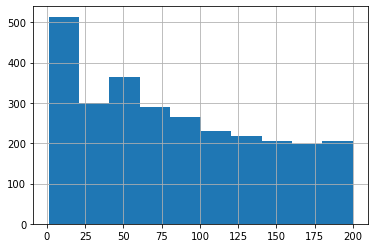

In [151]:
y1_df['year1_highest_position'].hist()

In [152]:
y1_df.groupby('year1_highest_position')['year1_avg_streams_p'].mean()

year1_highest_position
1.0      269719.006452
2.0      235814.750659
3.0      210328.984662
4.0      188055.351248
5.0      178918.416192
             ...      
196.0     23533.000000
197.0     20981.375000
198.0     20957.928571
199.0     21130.100000
200.0     20946.166667
Name: year1_avg_streams_p, Length: 200, dtype: float64

In [174]:
def position_class(x):
    if x>=1 and x<=10:
        x = 1
    elif x>=11 and x<=20:
        x = 2
    elif x>=21 and x<=30:
        x = 3
    elif x>=31 and x<=40:
        x = 4
    elif x>=41 and x<=50:
        x = 5
    elif x>=51 and x<=60:
        x = 6
    elif x>=61 and x<=70:
        x = 7
    elif x>=71 and x<=80:
        x = 8
    elif x>=81 and x<=90:
        x = 9
    elif x>=91 and x<=100:
        x = 10
    elif x>=101 and x<=110:
        x = 11
    elif x>=111 and x<=120:
        x = 12
    elif x>=121 and x<=130:
        x = 13
    elif x>=131 and x<=140:
        x = 14
    elif x>=141 and x<=150:
        x = 15
    elif x>=151 and x<=160:
        x = 16
    elif x>=161 and x<=170:
        x = 17
    elif x>=171 and x<=180:
        x = 18
    elif x>=181 and x<=190:
        x = 19
    elif x>=191 and x<=200:
        x = 20
    return x

y1_df['position_class'] = y1_df['year1_highest_position'].apply(position_class)
y1_df = y1_df[~y1_df.isna().any(1)]

In [175]:
y1_df['year1_highest_position'].value_counts()

1.0      86
2.0      37
6.0      36
52.0     30
5.0      29
         ..
186.0     5
171.0     5
185.0     5
164.0     5
196.0     4
Name: year1_highest_position, Length: 200, dtype: int64

In [176]:
y1_df['position_class'].value_counts()

1     325
6     208
2     189
3     167
5     157
7     154
8     137
10    136
4     132
9     129
11    116
12    114
13    114
16    108
18    105
20    105
14    103
19    100
15     97
17     92
Name: position_class, dtype: int64

In [177]:
y1_df['duration_mins']=y1_df['duration']/60000
y1_df['loudness'] = scaler.fit_transform(y1_df[['loudness']])
y1_df['tempo'] =  scaler.fit_transform(y1_df[['tempo']])
y1_df["position_class"] = y1_df["position_class"].astype('category')

In [178]:
# y1_df = y1_df[y1_df['position_class']!=11]

In [179]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

X = y1_df[feature_cols]
y = y1_df['position_class']

X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
print("Shape of X_Train:"+str(X_train.shape))
print("Shape of y_Train:"+str(Y_train.shape))
print("Shape of X_Test:"+str(X_test.shape))
print("Shape of y_Test:"+str(Y_test.shape))

Shape of X_Train:(2230, 8)
Shape of y_Train:(2230,)
Shape of X_Test:(558, 8)
Shape of y_Test:(558,)


In [180]:
from sklearn.svm import SVC

In [181]:
svm_model1 = SVC(kernel='linear')
pred1 = svm_model1.fit(X_train, Y_train)
print(classification_report(y,svm_model1.predict(X)))

              precision    recall  f1-score   support

           1       0.12      1.00      0.21       325
           2       0.00      0.00      0.00       189
           3       0.00      0.00      0.00       167
           4       0.00      0.00      0.00       132
           5       0.00      0.00      0.00       157
           6       0.18      0.01      0.03       208
           7       0.00      0.00      0.00       154
           8       0.00      0.00      0.00       137
           9       0.00      0.00      0.00       129
          10       0.00      0.00      0.00       136
          11       0.00      0.00      0.00       116
          12       0.00      0.00      0.00       114
          13       0.00      0.00      0.00       114
          14       0.00      0.00      0.00       103
          15       0.00      0.00      0.00        97
          16       0.00      0.00      0.00       108
          17       0.00      0.00      0.00        92
          18       0.00    

C:\Users\Patrisha Estrada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [182]:
svm_model2 = SVC(kernel='poly', degree=3, gamma=0.9)
pred2 = svm_model2.fit(X_train, Y_train)
print(classification_report(y,svm_model2.predict(X)))

              precision    recall  f1-score   support

           1       0.13      0.97      0.22       325
           2       0.35      0.04      0.08       189
           3       0.75      0.02      0.04       167
           4       0.29      0.02      0.03       132
           5       0.75      0.02      0.04       157
           6       0.28      0.09      0.13       208
           7       0.32      0.05      0.08       154
           8       0.18      0.09      0.12       137
           9       0.29      0.03      0.06       129
          10       0.50      0.05      0.09       136
          11       1.00      0.03      0.07       116
          12       0.88      0.06      0.11       114
          13       0.33      0.03      0.05       114
          14       0.44      0.08      0.13       103
          15       0.50      0.01      0.02        97
          16       0.67      0.04      0.07       108
          17       0.67      0.04      0.08        92
          18       0.50    

In [183]:
svm_model3 = SVC(kernel='rbf', gamma=0.8)
pred3 = svm_model3.fit(X, y)
print(classification_report(y,svm_model3.predict(X)))

              precision    recall  f1-score   support

           1       0.12      0.99      0.22       325
           2       0.19      0.03      0.05       189
           3       0.45      0.03      0.06       167
           4       0.00      0.00      0.00       132
           5       1.00      0.01      0.01       157
           6       0.22      0.11      0.14       208
           7       0.60      0.02      0.04       154
           8       0.33      0.01      0.01       137
           9       0.00      0.00      0.00       129
          10       1.00      0.01      0.01       136
          11       0.50      0.03      0.06       116
          12       0.00      0.00      0.00       114
          13       1.00      0.01      0.02       114
          14       0.75      0.03      0.06       103
          15       0.00      0.00      0.00        97
          16       0.00      0.00      0.00       108
          17       0.00      0.00      0.00        92
          18       0.00    

C:\Users\Patrisha Estrada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

X = y1_df[feature_cols]
y = y1_df['position_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(classification_report(y,clf.predict(X)))

              precision    recall  f1-score   support

           1       0.74      0.80      0.77       325
           2       0.63      0.74      0.68       189
           3       0.70      0.74      0.72       167
           4       0.65      0.76      0.70       132
           5       0.68      0.69      0.69       157
           6       0.68      0.66      0.67       208
           7       0.73      0.64      0.68       154
           8       0.68      0.73      0.71       137
           9       0.67      0.71      0.69       129
          10       0.70      0.64      0.67       136
          11       0.66      0.70      0.68       116
          12       0.64      0.65      0.64       114
          13       0.69      0.66      0.67       114
          14       0.74      0.63      0.68       103
          15       0.69      0.68      0.68        97
          16       0.74      0.67      0.70       108
          17       0.67      0.61      0.64        92
          18       0.74    